# Chapter 4 - Classification
- [4.1 An Overview of Classification](#An-Overview-of-Classification)
- [4.3 Logistic Regression](#4.3-Logistic-Regression)
- [4.4 Linear Discriminant Analysis](#4.4-Linear-Discriminant-Analysis)

## 4.1 An Overview of Classification

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('notebook')
%matplotlib notebook

In [3]:
filename = '../data/default.csv'
default_df = pd.read_csv(filename, index_col=0, dtype={'default': 'category', 'student': 'category'})
# in order for the logit function to work, statsmodels requires integer values for the categories
default_df['default'] = default_df['default'].cat.codes
default_df['student'] = default_df['student'].cat.codes

In [5]:
default_df.applymap('{:.1f}'.format).head()

,default,student,balance,income
1,0.0,0.0,729.5,44361.6
2,0.0,1.0,817.2,12106.1
3,0.0,0.0,1073.5,31767.1
4,0.0,0.0,529.3,35704.5
5,0.0,0.0,785.7,38463.5


In [4]:
default_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 4 columns):
default    10000 non-null int8
student    10000 non-null int8
balance    10000 non-null float64
income     10000 non-null float64
dtypes: float64(2), int8(2)
memory usage: 253.9 KB


In [5]:
default_df[['balance', 'income']].describe().applymap('{:.2f}'.format)

,balance,income
count,10000.00,10000.00
mean,835.37,33516.98
std,483.71,13336.64
min,0.00,771.97
25%,481.73,21340.46
50%,823.64,34552.64
75%,1166.31,43807.73
max,2654.32,73554.23


### Figure 4.1

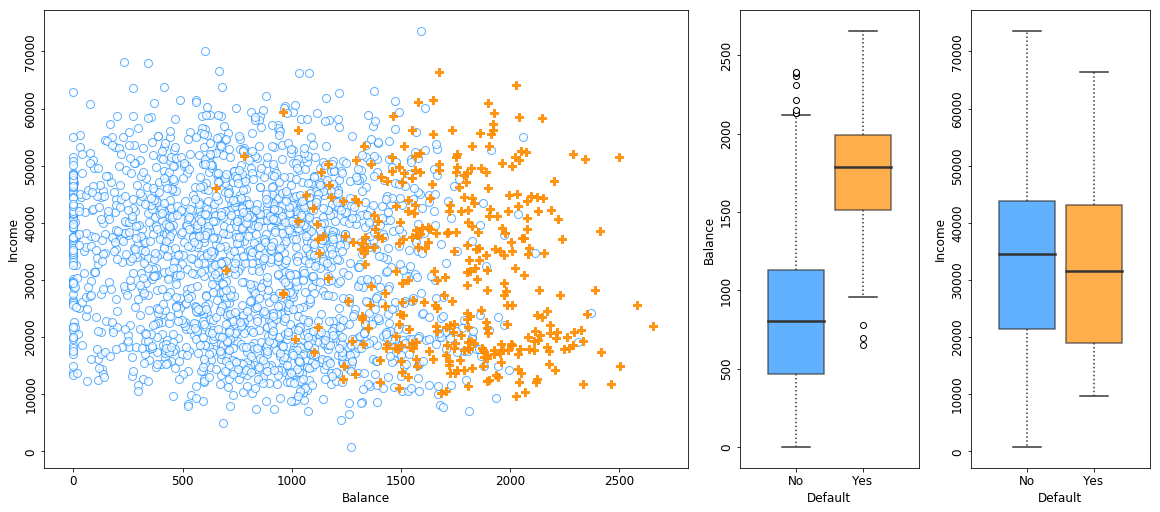

In [6]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(constrained_layout=True, figsize=(16, 7))
gs = GridSpec(1, 4, figure=fig)
ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[0, -2])
ax3 = fig.add_subplot(gs[0, -1])

colors = ['dodgerblue', 'darkorange']
facecolor=['white', 'darkorange']
markers = ['o', 'P']
cols = ['balance', 'income']
types = [0, 1]
labels = ['No', 'Yes']
alphas = [0.7, 0.9]
width=0.5

sample_default_NO_df = default_df.loc[default_df['default'] == 0].sample(frac=0.2)
default_YES_df = default_df.loc[default_df['default'] == 1]
sample_data = [sample_default_NO_df, default_YES_df]

for mk, ap, cl, fc, dt in zip(markers, alphas, colors, facecolor, sample_data):
    ax1.scatter(dt[cols[0]], dt[cols[1]], marker=mk, edgecolor=cl, facecolor=fc, alpha=ap)
    ax1.set_xlabel(cols[0].title())
    ax1.set_ylabel(cols[1].title())
    for tick in ax1.get_yticklabels():
        tick.set_rotation(90)
        tick.set_verticalalignment('center')

data = []
axes = [ax2, ax3]

for col in cols:
    tmp_data = []
    for ty in types:
        tmp_data.append(default_df.loc[default_df['default'] == ty, col].values)
    data.append(tmp_data)

for dt, col, ax in zip(data, cols, axes):
    bplot = ax.boxplot(dt, positions=[1.0, 1.6], widths=width, patch_artist=True, labels=labels)
    ax.set_xlabel('Default')
    ax.set_ylabel(col.title())
    for tick in ax.get_yticklabels():
        tick.set_rotation(90)
        tick.set_verticalalignment('center')
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('0.2')
        patch.set_linewidth(1.5)
        patch.set_alpha(0.7)
    for whisker in bplot['whiskers']:
        whisker.set_color('0.2')
        whisker.set_linewidth(1.5)
        whisker.set_linestyle(':')
    for fliers in bplot['fliers']:
        fliers.set_markerfacecolor('1.0')
        fliers.set_markeredgecolor('0.0')
    for median in bplot['medians']:
        median.set_color('0.2')
        median.set_linewidth(2.5)
    for caps in bplot['caps']:
        caps.set_color('0.2')
        caps.set_linewidth(1.5);

## 4.3 Logistic Regression

### Figure 4.2

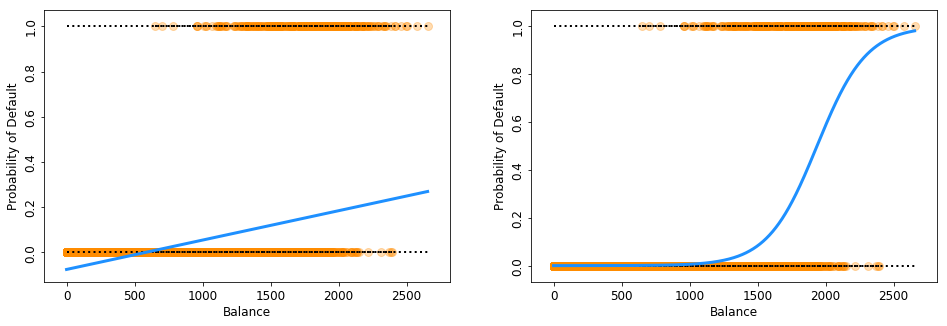

In [7]:
from sklearn.linear_model import LinearRegression, LogisticRegression

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

types = [0, 1]
data = []
rank_funcs = [np.zeros, np.ones]
rank = []

for type_, funcs in zip(types, rank_funcs):
    tmp_data = default_df.loc[default_df['default'] == type_]
    data.append(tmp_data)
    rank.append(funcs(len(tmp_data)))

lin_regr = LinearRegression()
log_regr = LogisticRegression(solver='lbfgs')

X = np.concatenate((data[0]['balance'].values, data[1]['balance'].values), axis=None).reshape(-1, 1)
y = np.concatenate((rank[0], rank[1]), axis=None).ravel()
lin_regr.fit(X, y)
log_regr.fit(X, y)

def model(x):
    return 1/(1 + np.exp(-x))

x_data = np.linspace(min(X), max(X), len(X))
y_lin_data = lin_regr.intercept_ + x_data * lin_regr.coef_
y_log_data = model(log_regr.intercept_ + x_data * log_regr.coef_)
plots = [y_lin_data.ravel(), y_log_data.ravel()]

for ax, pl in zip(axes, plots):
    ax.plot(x_data, pl, c='dodgerblue', lw=3)
    for dt, rk in zip(data, rank):
        ax.scatter(dt['balance'], rk, alpha=0.3, color='darkorange')
        for i in range(0,2):
            ax.hlines(i, xmin=dt['balance'].min(), xmax=dt['balance'].max(), linestyle=':')
    ax.set_xlabel('Balance')
    ax.set_ylabel('Probability of Default')
    for tick in ax.get_yticklabels():
        tick.set_rotation(90)
        tick.set_verticalalignment('center');

In [8]:
print('lin_regr.intercept_: {:1.4f}'.format(lin_regr.intercept_))
print('lin_regr.coef_: {:1.4f}'.format(lin_regr.coef_[0]))
print('log_regr.intercept_: {:1.4f}'.format(log_regr.intercept_[0]))
print('log_regr.coef_: {:1.4f}'.format(log_regr.coef_[0][0]))

lin_regr.intercept_: -0.0752
lin_regr.coef_: 0.0001
log_regr.intercept_: -10.6513
log_regr.coef_: 0.0055


### Table 4.1

In [9]:
import statsmodels.formula.api as smf
from patsy import dmatrices
y, X = dmatrices('default ~ balance', data=default_df, return_type='dataframe')
res = smf.Logit(y, X).fit()
res.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-10.6513,0.361,-29.491,0.000,-11.359,-9.943
balance,0.0055,0.000,24.952,0.000,0.005,0.006


In [10]:
for i in range(1000, 2200, 200):
    print('${0:d}, p(X): {1:1.1f}%'.format(i, 100*model(res.params[0] + res.params[1]*i)))

$1000, p(X): 0.6%
$1200, p(X): 1.7%
$1400, p(X): 5.0%
$1600, p(X): 13.6%
$1800, p(X): 32.0%
$2000, p(X): 58.6%


### Table 4.2

In [11]:
y, X = dmatrices('default ~ student', data=default_df, return_type='dataframe')
res1 = smf.Logit(y, X).fit()
res1.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-3.5041,0.071,-49.554,0.000,-3.643,-3.366
student,0.4049,0.115,3.520,0.000,0.179,0.630


In [12]:
for i in range(0,2):
    print('p(X): {:1.3f}%'.format(100*model(res1.params[0] + res1.params[1]*i)))

p(X): 2.920%
p(X): 4.314%


### Table 4.3

In [13]:
y, X = dmatrices('default ~ balance + income + student', data=default_df, return_type='dataframe')
res2 = smf.Logit(y, X).fit()
res2.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-10.8690,0.492,-22.079,0.000,-11.834,-9.904
balance,0.0057,0.000,24.737,0.000,0.005,0.006
income,3.033e-06,8.2e-06,0.370,0.712,-1.3e-05,1.91e-05
student,-0.6468,0.236,-2.738,0.006,-1.110,-0.184


### Figure 4.3

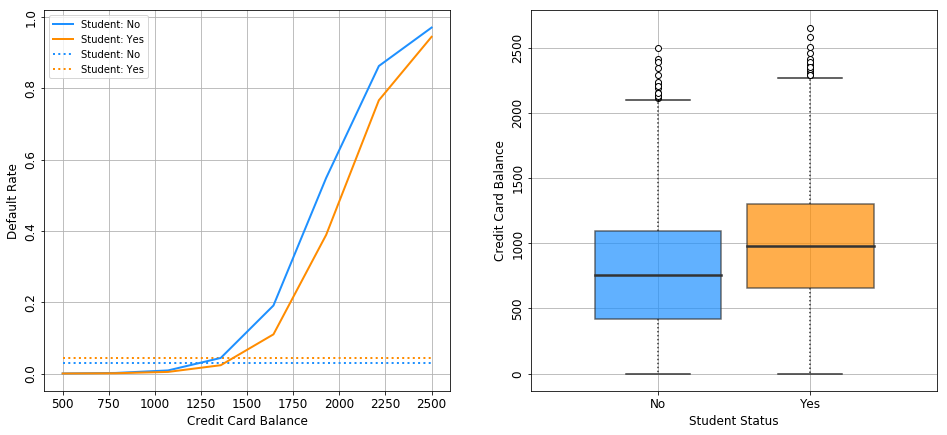

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

balance = np.linspace(500, 2500, 8)
income = 40 # in units of thousands

colors = ['dodgerblue', 'darkorange']
types = [0, 1]
labels = ['No', 'Yes']
student_labels = ['Student: No', 'Student: Yes']
width=0.5

# data arrays
data_balance = []
data_plots = []
for ty in types:
    data_balance.append(np.array(default_df.loc[default_df['student'] == ty, 'balance'].values))
    tmp_data = []
    for bl in balance:
        tmp_model = model(res2.params[0] + res2.params[1]*bl + res2.params[2]*income + res2.params[3]*ty)
        tmp_data.append(np.array(tmp_model))
    data_plots.append(tmp_data)

# first plot
for ty, cl, lb in zip(types, colors, student_labels):
    axes[0].plot(balance, data_plots[ty], color=cl, label=lb)
    tmp_st_dbt = np.array((model(res1.params[0] + res1.params[1]*ty)))
    axes[0].hlines(tmp_st_dbt, axes[0].xaxis.get_data_interval()[0], axes[0].xaxis.get_data_interval()[1], \
                   linestyles=':', color=cl, label=lb)
axes[0].set_xlabel('Credit Card Balance')
axes[0].set_ylabel('Default Rate')
axes[0].legend(loc='best')

# second plot
bplot = axes[1].boxplot(data_balance, positions=[1.0, 1.6], widths=width, patch_artist=True, labels=labels)
axes[1].set_xlabel('Student Status')
axes[1].set_ylabel('Credit Card Balance')
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('0.2')
    patch.set_linewidth(1.5)
    patch.set_alpha(0.7)
for whisker in bplot['whiskers']:
    whisker.set_color('0.2')
    whisker.set_linewidth(1.5)
    whisker.set_linestyle(':')
for fliers in bplot['fliers']:
    fliers.set_markerfacecolor('1.0')
    fliers.set_markeredgecolor('0.0')
for median in bplot['medians']:
    median.set_color('0.2')
    median.set_linewidth(2.5)
for caps in bplot['caps']:
    caps.set_color('0.2')
    caps.set_linewidth(1.5)

for ax in axes:
    for tick in ax.get_yticklabels():
        tick.set_rotation(90)
        tick.set_verticalalignment('center')
        ax.grid(True);

## 4.4 Linear Discriminant Analysis

### Table 4.4

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [39]:
X = default_df[['balance', 'income', 'student']]
y = default_df['default']
lda = LinearDiscriminantAnalysis(solver='svd')
y_pred = lda.fit(X, y).predict(X)

In [61]:
pred_df = pd.DataFrame({'True default status': y, 'Predicted default status': y_pred})
pred_df.replace(to_replace={0: 'No', 1: 'Yes'}, inplace=True)
pred_df.groupby(['Predicted default status', 'True default status']).size().unstack()

True default status,No,Yes
Predicted default status,,
No,9645,254
Yes,22,79


### Table 4.5

In [59]:
mod_thresh = 0.2
lda = LinearDiscriminantAnalysis(solver='svd')
y_prob = lda.fit(X, y).predict_proba(X)

In [63]:
prob_df = pd.DataFrame({'True default status': y, 'Predicted default status': y_prob[:, 1] > mod_thresh})
prob_df.replace(to_replace={0: 'No', 1: 'Yes'}, inplace=True)
prob_df.groupby(['Predicted default status', 'True default status']).size().unstack()

True default status,No,Yes
Predicted default status,,
No,9435,140
Yes,232,193


# Lab